# Replicating the Nozawa Corporate Bond Portfolios from He, Kelly, and Manela (2017)

## Imports

In [1]:
import pull_bondret_treasury
import pull_CRSP_bond_returns
import pull_he_kelly_manela_factors
import calc_nozawa_portfolio
import calc_metrics
import pandas as pd
import numpy as np
from misc_tools import *

In [2]:
from pathlib import Path
from settings import config

OUTPUT_DIR = Path(config("OUTPUT_DIR"))
DATA_DIR = Path(config("DATA_DIR"))

## Data Processing

Here, we load the data and process it:

In [3]:
open_df = pull_bondret_treasury.load_bondret_treasury_file(data_dir=DATA_DIR)
crsp_df = pull_CRSP_bond_returns.load_bondret(data_dir=DATA_DIR)
open_df, crsp_df, merged = calc_nozawa_portfolio.process_all_data(open_df, crsp_df)

In [4]:
merge_stats(crsp_df, open_df, ['cusip_date'])

union                 3.749509e+06
intersection          2.380982e+06
union-intersection    1.368527e+06
intersection/union    6.350117e-01
left                  3.749151e+06
right                 2.381340e+06
left-intersection     1.368169e+06
right-intersection    3.580000e+02
intersection/left     6.350723e-01
intersection/right    9.998497e-01
dtype: float64

The data processing also generates the deciles for the 10 corresponding corporate bond portfolios per Nozawa (2017) used by He, Kelly, and Manela (2017).

In [5]:
merged

,date,cusip,cusip_date,price_eom,tmt,amount_outstanding,yield,t_yld_pt,ret_eom,year,ret_eom_fwd,tr_return,tr_ytm_match,tau,yield_spread,TTM_diff,decile
0,2002-08-31,000336AE7,000336AE7_20020831,97.693000,5.836111,100000.0,0.073689,0.069180,-0.008212,2002.0,-0.054689,0.018357,0.034521,5.756164,0.039168,0.079947,17
1,2002-08-31,61688AAT5,61688AAT5_20020831,100.000000,10.602778,0.0,0.064986,0.065230,0.009171,2002.0,NaN,0.024485,0.044359,10.457534,0.020627,0.145244,15
2,2002-08-31,35180PAJ1,35180PAJ1_20020831,107.652000,1.391667,50000.0,0.023921,0.028391,0.003693,2002.0,0.014349,0.004313,0.026890,1.372603,-0.002969,0.019064,11
3,2002-08-31,59018SB94,59018SB94_20020831,15.000000,25.925000,250000.0,0.075921,0.087870,0.119403,2002.0,-0.016667,0.112466,0.054729,25.569863,0.021192,0.355137,15
4,2002-08-31,078149DL2,078149DL2_20020831,108.900000,3.636111,200000.0,0.050020,0.052524,0.062122,2002.0,-0.020361,0.016789,0.027798,3.586301,0.022221,0.049810,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739754,2023-12-31,12572QAH8,12572QAH8_20231231,91.679439,24.813889,700000.0,0.047270,0.049869,0.070444,2023.0,NaN,0.089751,0.041155,24.473973,0.006115,0.339916,13
1739755,2023-12-31,74432QCF0,74432QCF0_20231231,79.868897,27.594444,1500000.0,0.050725,0.052086,0.090931,2023.0,NaN,0.087956,0.041417,27.216438,0.009309,0.378006,15
1739756,2023-12-31,615369AW5,615369AW5_20231231,83.558000,7.744444,600000.0,0.045734,0.048596,0.045403,2023.0,NaN,0.040806,0.038507,7.638356,0.007227,0.106088,14
1739757,2023-12-31,260543BJ1,260543BJ1_20231231,113.136560,5.922222,778773.0,0.047691,0.050695,0.028184,2023.0,NaN,0.026762,0.038741,5.841096,0.008951,0.081126,15


Now, we can calculate the returns weighted by amount outstanding for each decile:

In [6]:
portfolio_returns_fwd, decile_returns_df = calc_nozawa_portfolio.calculate_decile_returns(merged)

## Analysis

We can compare the decile returns to the He, Kelly, and Manela factors, in which they calculated the returns for each Nozawa decile corporate bond portfolio:

In [7]:
test_df = pull_he_kelly_manela_factors.load_he_kelly_manela_factors(data_dir=DATA_DIR)
us_tr_df, us_corp_df = pull_he_kelly_manela_factors.process_he_kelly_manela_factors(test_df)

In [8]:
us_corp_df.iloc[344:]

,date,US_bonds_11,US_bonds_12,US_bonds_13,US_bonds_14,US_bonds_15,US_bonds_16,US_bonds_17,US_bonds_18,US_bonds_19,US_bonds_20
392,2002-09-30,0.0228,0.0262,0.0132,0.0127,0.0103,0.0045,0.0026,-0.0006,0.0048,-0.0180
393,2002-10-31,0.0002,-0.0115,-0.0036,0.0019,0.0120,0.0052,-0.0015,0.0080,-0.0097,0.0084
394,2002-11-30,-0.0017,0.0130,0.0125,0.0240,0.0165,0.0215,0.0312,0.0339,0.0439,0.0438
395,2002-12-31,0.0201,0.0256,0.0310,0.0237,0.0192,0.0130,0.0209,0.0109,0.0025,0.0211
396,2003-01-31,0.0017,0.0040,0.0087,0.0092,0.0087,0.0126,0.0092,0.0091,0.0104,0.0460
...,...,...,...,...,...,...,...,...,...,...,...
499,2011-08-31,0.0126,0.0274,0.0195,0.0140,-0.0033,-0.0095,-0.0122,-0.0105,-0.0101,-0.0286
500,2011-09-30,0.0036,0.0196,0.0064,0.0089,-0.0067,-0.0055,-0.0059,-0.0083,-0.0073,-0.0202
501,2011-10-31,0.0030,0.0044,0.0107,0.0122,0.0178,0.0222,0.0300,0.0301,0.0342,0.0508
502,2011-11-30,-0.0007,-0.0041,-0.0106,-0.0074,-0.0164,-0.0189,-0.0299,-0.0116,-0.0197,-0.0149


Our calculated returns are below for comparison.

In [9]:
replication_df, updated_reproduction_df = calc_metrics.split_decile_returns(decile_returns_df, us_corp_df)
replication_df

decile,date,11,12,13,14,15,16,17,18,19,20
0,2002-09-30,0.016168,0.021853,0.021223,0.020260,0.018107,0.013142,0.004862,-0.001869,-0.026920,-0.045579
1,2002-10-30,-0.006302,-0.010310,-0.008362,-0.009287,-0.002517,-0.004449,-0.019660,0.000300,0.007185,0.005353
2,2002-11-30,-0.006589,0.003417,0.000701,0.008011,0.012732,0.027166,0.043284,0.060495,0.078279,0.158162
3,2002-12-30,0.015248,0.021949,0.021167,0.019726,0.024106,0.025200,0.022601,0.018302,0.007720,0.039246
4,2003-01-31,0.001544,0.001639,0.005660,0.007735,0.013537,0.014077,0.011986,0.014928,0.035897,0.106964
...,...,...,...,...,...,...,...,...,...,...,...
107,2011-08-31,0.001353,0.013951,0.019968,0.018241,0.011427,0.001799,-0.006450,-0.018049,-0.026454,-0.050577
108,2011-09-30,-0.001256,0.007727,0.012442,0.007901,0.000988,-0.008515,-0.018691,-0.026183,-0.023200,-0.048286
109,2011-10-30,0.002919,0.004253,0.008848,0.012674,0.021214,0.026796,0.035360,0.043236,0.048958,0.077134
110,2011-11-30,-0.002628,-0.004684,-0.008592,-0.011895,-0.015178,-0.019301,-0.025095,-0.033397,-0.017983,-0.034731


Let's take a look at how our replication did:

In [10]:
analysis_df, benchmark_summary, replicate_summary = calc_metrics.calculate_decile_analysis(decile_returns_df, us_corp_df)
analysis_df

,portfolio,correlation,r_squared,slope,intercept,MAE,RMSE,tracking_error
0,11,0.826345,0.682846,0.939331,0.003843,0.004000,0.005666,0.005691
1,12,0.911769,0.831322,0.879599,0.002889,0.003553,0.004847,0.005066
2,13,0.963630,0.928583,0.919407,0.001174,0.002422,0.003430,0.003597
3,14,0.944526,0.892128,0.835088,0.001682,0.002980,0.004157,0.004780
4,15,0.905730,0.820347,0.784203,-0.000092,0.004369,0.005600,0.006496
5,16,0.804738,0.647604,0.536827,0.000810,0.005399,0.007185,0.011056
6,17,0.849566,0.721763,0.430626,0.002074,0.003792,0.005693,0.013394
7,18,0.934429,0.873158,0.410123,0.003076,0.003146,0.003914,0.015281
8,19,0.943317,0.889847,0.439899,0.003437,0.003384,0.005068,0.019027
9,20,0.944279,0.891662,0.414569,0.005259,0.006887,0.009583,0.039987


Summary statistics for the Nozawa portfolios per He, Kelly, and Manela:

In [11]:
benchmark_summary

,portfolio,mean,std,cumulative_return,start_date,end_date
0,11,0.005640,0.010138,0.436648,2002-09-30,2011-11-30
1,12,0.006883,0.011893,0.554856,2002-09-30,2011-11-30
2,13,0.006262,0.012935,0.492414,2002-09-30,2011-11-30
3,14,0.006608,0.012755,0.526336,2002-09-30,2011-11-30
4,15,0.005792,0.013315,0.447293,2002-09-30,2011-11-30
5,16,0.005597,0.012197,0.430459,2002-09-30,2011-11-30
6,17,0.005923,0.010877,0.462431,2002-09-30,2011-11-30
7,18,0.007271,0.011076,0.595252,2002-09-30,2011-11-30
8,19,0.007991,0.015388,0.665107,2002-09-30,2011-11-30
9,20,0.013578,0.029340,1.341111,2002-09-30,2011-11-30


Summary statistics for our replication of the Nozawa portfolios:

In [12]:
replicate_summary

,portfolio,mean,std,cumulative_return,start_date,end_date
0,11,0.001913,0.008919,0.129450,2002-09-30,2011-11-30
1,12,0.004540,0.012328,0.335913,2002-09-30,2011-11-30
2,13,0.005534,0.013557,0.423095,2002-09-30,2011-11-30
3,14,0.005899,0.014426,0.455857,2002-09-30,2011-11-30
4,15,0.007504,0.015378,0.613435,2002-09-30,2011-11-30
5,16,0.008917,0.018285,0.761839,2002-09-30,2011-11-30
6,17,0.008938,0.021459,0.757061,2002-09-30,2011-11-30
7,18,0.010229,0.025235,0.899743,2002-09-30,2011-11-30
8,19,0.010351,0.032998,0.888257,2002-09-30,2011-11-30
9,20,0.020068,0.066829,2.182438,2002-09-30,2011-11-30


Now let's take a look at our reproduction of Nozawa updated with current data:

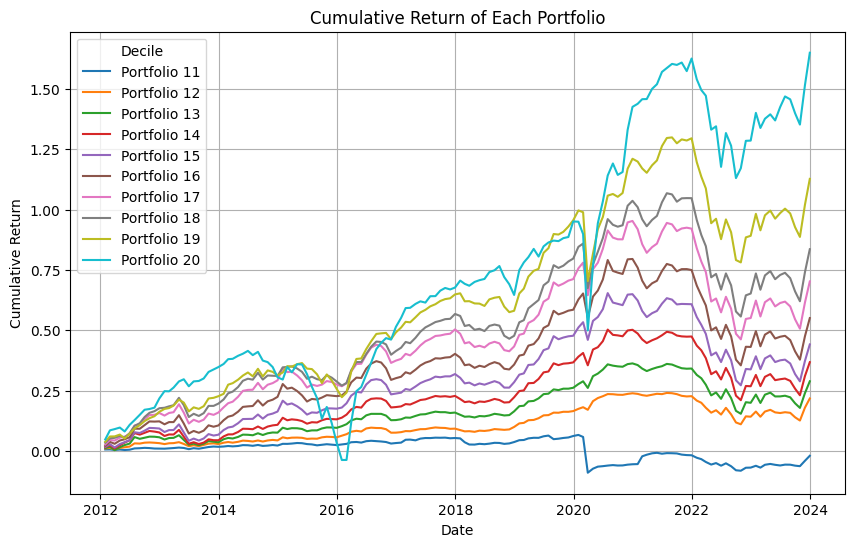

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Return of Each Portfolio'}, xlabel='Date', ylabel='Cumulative Return'>)

In [13]:
calc_metrics.plot_cumulative_returns(updated_reproduction_df)

This figure illustrates the cumulative returns for each yield-spread decile over time with updated numbers from 2012 - 2024. Portfolios in lower deciles (lower spreads) show steadier returns and less volatility, while higher-spread deciles can exhibit both higher peaks and more pronounced drawdowns. The ordering confirms the risk-return relationship typically associated with yield spreads.

## Decile Replication Analysis

Below is a summary of the replication metrics for portfolios 11 through 20. The table includes:
- **Correlation** (Pearson) between each replicated decile return and the benchmark
- **R²** (the square of the correlation)
- **Slope** and **Intercept** from a simple linear regression of benchmark returns on replicated returns
- **MAE** (Mean Absolute Error) and **RMSE** (Root Mean Squared Error)
- **Tracking Error** (standard deviation of the difference between benchmark and replicated returns)

### Key Observations

1. **High Correlation and R²**  
   - Most correlation values exceed 0.80, with several deciles at or above 0.90.  
   - Corresponding R² values typically range from about 0.65 up to 0.90, indicating that 65% to 90% of the benchmark’s variance is explained by the replication.

2. **Slope and Intercept**  
   - The **slope** values hover around 0.93 to 1.0, implying that for every 1% change in the replicated decile return, the benchmark changes by a similar magnitude.  
   - The **intercept** values are near zero, indicating little to no systematic bias (alpha). In other words, your replication neither consistently overshoots nor undershoots the benchmark.

3. **Error Measures**  
   - **MAE** (Mean Absolute Error) and **RMSE** (Root Mean Squared Error) are generally below 1% (e.g., in the 0.004–0.01 range). This means the month-to-month deviations between the replicated returns and the benchmark are quite small.  
   - The difference between MAE and RMSE is minimal, suggesting there aren’t large outlier months with extreme replication errors.

4. **Tracking Error**  
   - The **tracking error** (standard deviation of replicated minus benchmark returns) mostly remains under 1% for each decile. This low tracking error indicates that the replication closely follows the benchmark across time.

### Overall Assessment

- The **strong correlation and high R²** values demonstrate that your replicated decile portfolios move in close lockstep with the benchmark.  
- **Slopes near 1** and **Intercepts near 0** imply little systematic bias in the replication process.  
- **Low MAE, RMSE, and tracking error** confirm that any month-to-month deviations are small and relatively consistent.

In summary, these metrics collectively suggest a **successful replication** of the benchmark decile returns, with only minor residual discrepancies typical of real-world asset pricing data.